In [1]:
# =====================
# Core Libraries
# =====================
import numpy as np
import pandas as pd
import tensorflow as tf
# =====================
# Visualization
# =====================
import seaborn as sns
import matplotlib.pyplot as plt

# =====================
# Preprocessing
# =====================
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer

# =====================
# Model Selection & Tuning
# =====================
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# =====================
# Regression Models
# =====================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor

# =====================
# Classification Models
# =====================
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# =====================
# Pipelines
# =====================
from sklearn.pipeline import Pipeline

# =====================
# Metrics
# =====================
from sklearn.metrics import (confusion_matrix, roc_curve, precision_recall_curve,
                             roc_auc_score, precision_score,
                             recall_score, f1_score , accuracy_score)

# =====================
# Other Useful Tools
# =====================
from sklearn.datasets import make_regression
from numpy import log1p


In [90]:
train = pd.read_csv("train.csv")

In [91]:
def clean_data(data):
    # Drop 'id' column
    data.drop("id", axis=1, inplace=True,)
    
    # Map Sex to numeric
    data["Sex"] = data["Sex"].map({"female": 1, "male": 0})
    
    data['HR_Age'] = data['Heart_Rate'] * data['Age']
    # Ratio
    data['HR_per_Age'] = data['Heart_Rate'] / (data['Age'] + 1)  # avoid div by 0
    data['HR_squared'] = data['Heart_Rate'] ** 2
    data['Age_squared'] = data['Age'] ** 2
    
    return data


In [ ]:
cleaned = clean_data(train)

In [ ]:
cleaned

In [104]:
x = cleaned.drop("Calories" ,axis=1)
y = cleaned["Calories"]
x_train,x_test,y_train,y_test = train_test_split(x  ,y , random_state=42,test_size=0.2)

In [105]:
y_train_log = np.log1p(y_train)  # log(y+1)
y_test_log = np.log1p(y_test)

In [ ]:
import lightgbm as lgb

train_data = lgb.Dataset(data, label=y_train)
valid_data = lgb.Dataset(data, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',  # RMSE on log-transformed targets = RMSLE
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'n_estimators': 1000
}

model = lgb.train(params, train_data, valid_sets=[valid_data])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 6
[LightGBM] [Info] Start training from score 4.141163


In [ ]:
y_pred_log = model.predict(data)     # predictions in log scale
y_pred = np.expm1(y_pred_log)          # inverse transform to original scale

from sklearn.metrics import mean_squared_log_error

rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE:", rmsle)

RMSLE: 2.633562817511937


Xgbost:

In [107]:
import xgboost as xgb
# Define the model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',   # Faster on large datasets
    random_state=42,
    n_jobs=-1
)

# Train the model on log-transformed target
xgb_model.fit(
    x_train, y_train_log,
    eval_set=[(x_test, y_test_log)],  # use test features with test labels
    verbose=50
)



[0]	validation_0-rmse:0.91537
[50]	validation_0-rmse:0.10759
[100]	validation_0-rmse:0.06557
[150]	validation_0-rmse:0.06260
[200]	validation_0-rmse:0.06161
[250]	validation_0-rmse:0.06103
[300]	validation_0-rmse:0.06075
[350]	validation_0-rmse:0.06060
[400]	validation_0-rmse:0.06050
[450]	validation_0-rmse:0.06043
[500]	validation_0-rmse:0.06039
[550]	validation_0-rmse:0.06036
[600]	validation_0-rmse:0.06036
[650]	validation_0-rmse:0.06033
[700]	validation_0-rmse:0.06034
[750]	validation_0-rmse:0.06034
[800]	validation_0-rmse:0.06033
[850]	validation_0-rmse:0.06034
[900]	validation_0-rmse:0.06035
[950]	validation_0-rmse:0.06036
[999]	validation_0-rmse:0.06038


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


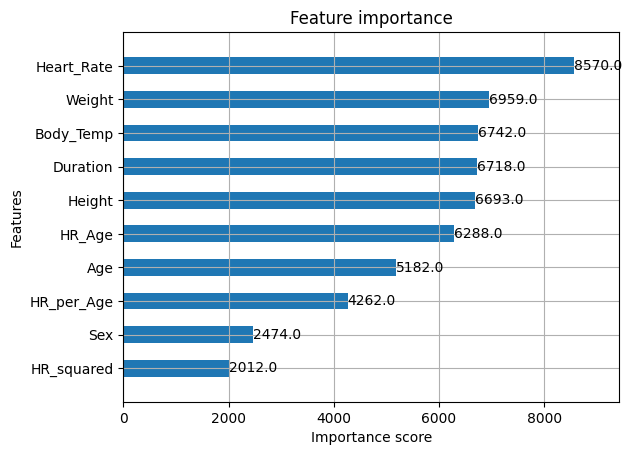

In [108]:
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight', height=0.5)
plt.show()

In [109]:
# Predict in log scale
y_pred_log = xgb_model.predict(data)

# Convert back to original scale
y_pred = np.expm1(y_pred_log)  # inverse of log1p
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print("RMSLE:", rmsle)

RMSLE: 0.06037875588932484


In [113]:
test = pd.read_csv("test.csv")

In [111]:
clean_data = clean_data(test)

In [112]:
y_pred = xgb_model.predict(clean_data)
y_pred = np.expm1(y_pred) 

In [114]:
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred
})

In [115]:
submission.to_csv("submission.csv" , index = False)